In [ ]:
"""
@Josh Boquiren
Ver. I
OTIS Lab MUSC
1.21.2023

README: 
//Revised version of "Population - PFC Self-Admin 7.2.ipynb"//

NOTES:
- break down population analysis method into smaller methods

"""

## Prepatory Work

In [1]:
#basic tool imports
import numpy as np
import pandas as pd
import polars as pl #going to test speed between pandas and polars
from numba import jit #for compiling methods; compiling increases run time
import os
import scipy.io as sio

### 2p imaging variables

In [2]:
frame_averaging = 4
time_between_frames = 33.3333
frame_rate = time_between_frames/frame_averaging #raw frame rate
averaged_frame_rate = time_between_frames/frame_averaging #averaged frame rate

### Assigning directories

Experimental data

In [3]:
#base directory
base_dir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\EXPERIMENTAL DATA'

#reinstatement directories
early_rein_dir = "CueRein"
middle_rein_dir = "DrugRein"
late_rein_dir = "TMTRein"
rein = [early_rein_dir, middle_rein_dir, late_rein_dir]

#acquisition directories
early_acq_dir = "EarlyAcq"
middle_acq_dir = "MidAcq"
late_acq_dir = "LateAcq"
acq = [early_acq_dir, middle_acq_dir, late_acq_dir]

#exctinction directories
early_ext_dir = "EarlyExt"
late_ext_dir = "LateExt"
ext = [early_ext_dir, late_ext_dir]

Folder format:
___
Project condition
    
    -> Animals
        -> FOV_Tracked
            -> Behavior
                -> Parts
            -> Tracking
                -> Days

In [4]:
#verifying folder organization
for condition in rein:
    print("[",condition,"]")
    print("Animals:")
    for animal in os.listdir(os.path.join(base_dir, condition, 'Animals')):
        print("@", animal)
        for i in os.listdir(os.path.join(base_dir, condition, 'Animals', animal, 'FOV1_tracked')):
            if i == 'Behavior' or i =='Tracking':
                print("===>", i)
                for j in os.listdir(os.path.join(base_dir, condition, 'Animals', animal, 'FOV1_tracked', i)):
                    print("--------->", j) 
                    if j == 'Part_1' or j == 'Part_2' or j == 'Part_3' or j == 'Days':
                        for k in os.listdir(os.path.join(base_dir, condition, 'Animals', animal, 'FOV1_tracked', i, j)):
                            print("--------------->", k)
                    else:
                        print("--------->", j) 
            else:
                print("--->", i)
    print()

[ CueRein ]
Animals:
@ CTL1
===> Behavior
---------> Part_1
---------------> HH-CTL1_2P-HER_RST_CUE_PrL-FOV1_0_6000_200109-144229.mat
---------------> T2_HH-CTL1_2P-HER_RST-CUE_PrL-FOV1_behavior-000_extractedsignals_raw.npy
---> deconvolved_traces_per_session.npy
---> spikeinf_list_per_session.npy
===> Tracking
---------> Days
---------------> CTL1_All-Days_Cell-Tracking.csv
---------------> CTL1_PFC-GCaMP6s_RST_Cell-Tracking_CUE-DRUG-TMT.csv
---------> FOV1_tracked_cluster_list_per_fov_CueDrugTMT.npy
---------> FOV1_tracked_cluster_list_per_fov_CueDrugTMT.npy
@ ER-L1
===> Behavior
---------> Part_1
---------------> ER-L1_2P-HER_RST_CUE_PrL-FOV1_0_6000_200109-105710.mat
---------------> T2_ER-L1_2P-HER_RST-CUE_PrL-FOV1_behavior-000_extractedsignals_raw.npy
---> deconvolved_traces_per_session.npy
---> spikeinf_list_per_session.npy
===> Tracking
---------> Days
---------------> ER-L1_All-Days_Cell-Tracking.csv
---------------> ER-L1_PFC-GCamP6s_RST_Cell-Tracking_CUE-DRUG-TMT.csv
--------

### Animals of interest

In [110]:
#reinstatement animals of interest
early_animals_reinstatement = [
    'CTL1',
    'ER-L1','ER-L2',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
middle_animals_reinstatement = [
    'CTL1',
    'ER-L1','ER-L2',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
late_animals_reinstatement = [
    'CTL1',
    'ER-L1','ER-L2',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ] 

In [111]:
#acquisition animals of interest
early_animals_acqisition = [
    'CTL1',
    'ER-L1','ER-L2',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
middle_animals_acquisition = [
    'CTL1',
    'ER-L1','ER-L2',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
late_animals_acquisition = [
    'CTL1',
    'ER-L1','ER-L2',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  

In [112]:
#extinction animals of interest
early_animals_extinction = [
    'CTL1',
    'ER-L1','ER-L2',
    'LCDD-PGa1','LCDD-PGa4','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T3','LCDD-PGa-T4',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
middle_animals_extinction = [
    'CTL1',
    'ER-L1','ER-L2',
    'LCDD-PGa1','LCDD-PGa5',
    'LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2'
    ]  
late_animals_extinction = [
    'CTL1',
    'ER-L1','ER-L2',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
]  

In [5]:
#testing data
early_test = [
    'CTL1',
    'ER-L1','ER-L2',
    'LCDD-PGa1',
    'jkasdf'
    ]  
middle_test = [
    'CTL1',
    'ER-L1','ER-L2'
    ]  
late_test = [
    'CTL1',
    'ER-L1','ER-L2'
]  

In [6]:
#checking to make sure animals in folders exist in aoi list ***aoi = animals of interest***
for condition in rein:
    print("[",condition,"]")
    for aoi in os.listdir(os.path.join(base_dir, early_acq_dir, 'Animals')):
        ans = bool(aoi in early_test)
        print("@", aoi, " : ", ans)
    print()

[ CueRein ]
@ CTL1  :  True
@ ER-L1  :  True
@ ER-L2  :  True
@ IG-19  :  False
@ LCDD-PGa-T1  :  False
@ LCDD-PGa-T2  :  False
@ LCDD-PGa-T3  :  False
@ LCDD-PGa-T4  :  False
@ LCDD-PGa-T5  :  False
@ LCDD-PGa1  :  True
@ LCDD-PGa3  :  False
@ LCDD-PGa4  :  False
@ LCDD-PGa5  :  False
@ LCDD-PGa6  :  False
@ PGa-T1  :  False
@ PGa-T2  :  False
@ PGa-T3  :  False

[ DrugRein ]
@ CTL1  :  True
@ ER-L1  :  True
@ ER-L2  :  True
@ IG-19  :  False
@ LCDD-PGa-T1  :  False
@ LCDD-PGa-T2  :  False
@ LCDD-PGa-T3  :  False
@ LCDD-PGa-T4  :  False
@ LCDD-PGa-T5  :  False
@ LCDD-PGa1  :  True
@ LCDD-PGa3  :  False
@ LCDD-PGa4  :  False
@ LCDD-PGa5  :  False
@ LCDD-PGa6  :  False
@ PGa-T1  :  False
@ PGa-T2  :  False
@ PGa-T3  :  False

[ TMTRein ]
@ CTL1  :  True
@ ER-L1  :  True
@ ER-L2  :  True
@ IG-19  :  False
@ LCDD-PGa-T1  :  False
@ LCDD-PGa-T2  :  False
@ LCDD-PGa-T3  :  False
@ LCDD-PGa-T4  :  False
@ LCDD-PGa-T5  :  False
@ LCDD-PGa1  :  True
@ LCDD-PGa3  :  False
@ LCDD-PGa4  :  False


### Behavior data

In [7]:
#initializing behavior data
behavior_data = sio.loadmat(os.path.join(base_dir, "Codes", "matfile_noframes_3.mat")) #no frames <-- what does no frames mean?

#lever press (eventlog) data
eventlog = np.squeeze(behavior_data['eventlog']) #no frames

In [8]:
#max of all rows, second column
max_eventlog = max(eventlog[:,1]) 

#length of columns...technically
length_eventlog = len(eventlog[:,1]) 

#don't know why, but we're stacking eventlog 3x
temp_vstack = np.vstack((eventlog, eventlog, eventlog)) 

#adding max of eventlog to all values starting from 2nd stack to the last row in the second column
temp_vstack[length_eventlog:,1]= temp_vstack[length_eventlog:,1]+max_eventlog 

#adding 2*max of eventlog to all values starting from the 3rd stack to the last row in the second column
temp_vstack[length_eventlog*2:,1]= temp_vstack[length_eventlog*2:,1]+(2*max_eventlog)

#new eventlog with added maxes
neweventlog = temp_vstack

### Methods for artificially adding frames

In [9]:
def fix_any_dropped_frames(frame_timestamps):
    first_frame = np.array([0])
    last_frame = np.array([int(np.max(frame_timestamps)+(500*time_between_frames))])

    #add frame to timepoint '0' and an extra 500 frames at end
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame))

    #create empty list for us to add timestamps for missed frames
    frames_missed = []

    #iterates through each collected frame
    for i in range(len(frame_index_temp)-1): 
            numframes_missed = int(np.round((frame_index_temp[i+1]-frame_index_temp[i])\
                /time_between_frames)-1) ### number of missed frames per frame interval
            if numframes_missed > 0: 
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(time_between_frames * (j+1)))])
                    frames_missed = np.concatenate((frames_missed, frame_missed))
                    
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed))))
    return corrected_frame_index

def fix_assumed_frames(frames):
    dropped_frames = []
    diff_frames = np.diff(frames)
    inter_frame_interval = 33
    frame_drop_idx = np.where(diff_frames>1.5*inter_frame_interval)[0]
    for idx in frame_drop_idx:
        numframesdropped = int(np.round((frames[idx+1]-frames[idx])/(inter_frame_interval+0.0))-1)
        temp = [frames[idx]+a*inter_frame_interval for a in range(1,numframesdropped+1)]
        dropped_frames.extend(temp)


    corrected_frames = np.sort(np.concatenate((frames, np.array(dropped_frames))))
    return corrected_frames

### Artifically adding frames

In [72]:
###Provides about 4.32 hours worth of frames if 4 frame averaging)
assumed_frames = fix_any_dropped_frames(neweventlog[neweventlog[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
assumed_frame_timestamps = fix_assumed_frames(neweventlog[neweventlog[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO

# Population Analysis

In [11]:
#plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

### Window, baseline, and infusion frame settings

In [12]:
pre_window_size = int(10*frame_rate) #How many frames per trial before origin to be plotted?
print("Pre-window size: ", pre_window_size)

window_size =  int((pre_window_size*2)+(3*frame_rate)) #How many frames do you want to plot around the origin?
print("Window size: ", window_size)

post_window_size = window_size - pre_window_size
print("Post-window size: ", post_window_size)

baselinefirstframe = 0
print("First frame of baseline: ", baselinefirstframe)

baselinelastframe = int(1*frame_rate)
print("Last frame of baseline: ",  baselinelastframe)

infusionframe = int(pre_window_size+(3*frame_rate))
print("Infusion frame: ", infusionframe)

Pre-window size:  83
Window size:  190
Post-window size:  107
First frame of baseline:  0
Last frame of baseline:  8
Infusion frame:  107


### Tracking, sorting, and window size settings

In [13]:
tracking = input("Do you wish to do cell tracking? Type 'Yes' or 'No'") #originally set to Yes
print("Tracking set to: ", tracking)

sorting = input("Do you wish to do cell sorting? Type 'Yes' or 'No'") #originally set to No
print("Sorting set to: ", sorting)

sorttoearly = input("Do you wish to do cell tracking? Type 'Yes' or 'No'") #orignally No; This is for sorting, but align to early data. 'Sorting' must also be Yes
print("Sort to early set to: ", sorttoearly)

#select your tracking CSV IDs if you're doing tracking. Comment out the other.
# csv_id_for_tracking = 'SCT-ScramControl'
csv_id_for_tracking = 'CUE-DRUG-TMT'

#assign frames you want to plot
pre_window_size = int(10*frame_rate) #rate))
print("Pre-window size set to: ", pre_window_size)

Tracking set to:  Yes
Sorting set to:  No
Sort to early set to:  No
Pre-window size set to:  83


### Tracking cells

In [14]:
#creates tracking arrays
if tracking == 'Yes':
    population_active_tracked_early = np.nan*np.ones((1,window_size))
    population_active_tracked_middle = np.nan*np.ones((1,window_size))
    population_active_tracked_late = np.nan*np.ones((1,window_size))
    print ('Cell Tracking')
else:
    print ('No Cell Tracking')

Cell Tracking


### Method for population analysis

In [15]:
#test folder
indir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\EXPERIMENTAL DATA\CueRein\Animals'
print("INDIR:\n", os.listdir(indir))
mice = [i for i in os.listdir(indir) if i in early_test]
print("ANIMALS TO TEST:\n", mice)


INDIR:
 ['CTL1', 'ER-L1', 'ER-L2', 'IG-19', 'LCDD-PGa-T1', 'LCDD-PGa-T2', 'LCDD-PGa-T3', 'LCDD-PGa-T4', 'LCDD-PGa-T5', 'LCDD-PGa1', 'LCDD-PGa3', 'LCDD-PGa4', 'LCDD-PGa5', 'LCDD-PGa6', 'PGa-T1', 'PGa-T2', 'PGa-T3']
ANIMALS TO TEST:
 ['CTL1', 'ER-L1', 'ER-L2', 'LCDD-PGa1']


In [16]:
#writing method out as code first
for mouse in mice:

    #open folder containing behavior parts
    behavior_parts = os.listdir(os.path.join(indir, mouse, 'FOV1_tracked', 'Behavior'))

    #separate .npy and .mat files
    npyfiles = []
    eventlogs = []
    licks = []
    timestamps = []
    for part in behavior_parts:
        part_folder = os.listdir(os.path.join(indir, mouse, 'FOV1_tracked', 'Behavior', part))
        for file in part_folder:
            if file.endswith(".npy"):
                file = np.load(os.path.join(indir, mouse, 'FOV1_tracked', 'Behavior', part, file))
                npyfiles.append(np.squeeze(file))
            elif file.endswith(".mat"):
                file = sio.loadmat(os.path.join(indir, mouse, 'FOV1_tracked', 'Behavior', part, file))
                eventlogs.append(np.squeeze(file['eventlog']))
                timestamps.append(np.max(np.squeeze(file['eventlog'])))
                licks.append(np.squeeze(file['licks']))

    #constructing signal data
    signals = np.hstack(([f for f in npyfiles])) #hstacked all arrays in npyfiles
    signals /= np.mean(signals, axis=1)[:, None]
    signalsT = signals.T

    #combining and assigning eventlog data
    eventlog = np.concatenate(([f for f in eventlogs]))
    active_lever = eventlog[eventlog[:,0]==22,1] #for all rows of eventlog where col[0] is 22, pull the value from col[1]
    active_lever_timeout = eventlog[eventlog[:,0]==222,1] #for all rows of eventlog where col[0] is 2, pull the value from col[1]
    inactive_lever = eventlog[eventlog[:,0]==21,1]
    inactive_lever_timeout = eventlog[eventlog[:,0]==212,1]
    cues = eventlog[eventlog[:,0]==7,1]
    infusions = eventlog[eventlog[:,0]==4,1]

    #combining lick data
    licks = np.concatenate(([f for f in licks]))


In [69]:
#original method
def analyze_single_session(indir, window_size, pre_window_size):
        
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
        and 'extractedsignals_raw' in f]
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat']

    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
            and 'extractedsignals_raw' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' 
            and not 'results' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]
    
    signals = np.squeeze(np.load(os.path.join(indir, npyfile)))
    numrois = signals.shape[0] 
   
    behaviordata = sio.loadmat(os.path.join(indir, matfile))
    eventlog = np.squeeze(behaviordata['eventlog'])
    licks = np.squeeze(behaviordata['licks'])
    lastframe_timestamp_part1 = np.max(eventlog)
    
    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part2' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2))) 
        signals = np.hstack((signals, signals2))

        
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1]+lastframe_timestamp_part1  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog2))
        lastframe_timestamp_part2 = np.max(eventlog)
        
        
        licks2 = np.squeeze(behaviordata2['licks'])
        licks2 = licks2+lastframe_timestamp_part1
        licks = np.concatenate ([licks, licks2])
        
    if len(npyfiles) > 2:
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part3' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3))) 
        signals = np.hstack((signals, signals3))
        
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1]+lastframe_timestamp_part2  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog3))
        lastframe_timestamp_part3 = np.max(eventlog)
        
        
        licks3 = np.squeeze(behaviordata3['licks'])
        licks3 = licks3+lastframe_timestamp_part2
        licks = np.concatenate ([licks, licks3])
    
    if len(npyfiles) > 3:
        npyfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' and 'part4' in f]
        matfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part4' in f and not 'results' in f]
        
        npyfile4 = npyfiles4[0]
        matfile4 = matfiles4[0]
        
        signals4 = np.squeeze(np.load(os.path.join(indir, npyfile4))) 
        signals = np.hstack((signals, signals4))
        
        behaviordata4 = sio.loadmat(os.path.join(indir, matfile4))
        
        eventlog4 = np.squeeze(behaviordata4['eventlog'])
        eventlog4[:,1] = eventlog4[:,1]+lastframe_timestamp_part3  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog4))
        lastframe_timestamp_part4 = np.max(eventlog)
        
        
        licks4 = np.squeeze(behaviordata4['licks'])
        licks4 = licks4+lastframe_timestamp_part3
        licks = np.concatenate ([licks, licks4])
    
    
    ###THIS SECTION DEFINES CERTAIN INPUTS IN EVENTLOG AS BEHAVIORAL STIMULI (LEVER PRESS, CUE, ETC)
    activelever = eventlog[eventlog[:,0]==22,1]
    activelevertimeout = eventlog[eventlog[:,0]==222,1]
    inactivelever = eventlog[eventlog[:,0]==21,1]
    inactivelevertimeout = eventlog[eventlog[:,0]==212,1]
    cues = eventlog[eventlog[:,0]==7,1]
    infusions = eventlog[eventlog[:,0]==4,1]
    
#     print(activelever.shape, '=activelever')
#     print(activelevertimeout.shape,'=activelevertimeout')
    
    signals /= np.mean(signals, axis=1)[:, None]
    signalsT = signals.T
    

###UP TO HERE REWRITTEN


    """DO THIS PART SEPARATE"""
    ###IF YOUR CODE LACKS FRAME INPUTS, WE CAN ATTEMPT TO PREDICT FRAME TIMING BY USING PREVIOUS FRAME TIMESTAMPS
    if animal == 'CTL1' or animal == 'ER-L1' or animal == 'ER-L2' or animal == 'IG-19' or animal == 'IG-28' or animal == 'PGa-T1' or animal == 'XYZ':
        frame_timestamps = assumed_frame_timestamps ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    else:
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:,0]==9,1])
        
    frame_timestamps = frame_timestamps[::frame_averaging] ###incorporates averaging into timestamp array
    
    """NEW PART"""
    ###DISCARDS BEHAVIORAL EVENTS THAT WERE NOT FULLY MONITORED WITH IMAGING
    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0]-1] ###cuts signals so it's not longer than the frame timestamps
    final_frame_timestamp = frame_timestamps[signals.shape[1]] #This is the timestamp of the final frame in milliseconds
    activelever = activelever[activelever<(final_frame_timestamp-(window_size/frame_rate*1000))]
    activelevertimeout = activelevertimeout[activelevertimeout<(final_frame_timestamp-(window_size/frame_rate*1000))]
    inactivelever = inactivelever[inactivelever<(final_frame_timestamp-(window_size/frame_rate*1000))]
    inactivelevertimeout = inactivelevertimeout[inactivelevertimeout<(final_frame_timestamp-(window_size/frame_rate*1000))]
    
    seconds_monitored = int(signals.shape[1]/averaged_frame_rate) ###seconds monitored by 2p imaging
    seconds_behavior = int(max(activelever/1000)) ###final seconds to be monitored for behavior

    """NEW PART"""
    if seconds_monitored < seconds_behavior: #calculates last fully-monitored active lever press with 2p recording
        included_trials = []
        discarded_trials=[]
        for i in range(len(activelever)):
            if activelever[i]/1000<seconds_monitored:
                included_trials=np.append(included_trials, activelever[i])
            else:
                discarded_trials=np.append(discarded_trials,activelever[i])
        activelever=included_trials
#         print ('The behavioral file is longer than the imaging file. We discarded n = ', len(discarded_trials), ' active lever presses')
#         print ('and included n = ', len(included_trials), ' active lever presses')   
        
#     signals /= np.nanmean(signals, axis=1)[:, None]
#     signalsT = signals.T    
    
    """NEW PART"""
    ###COMBINES ALL PRESSES
    activeleverall = np.hstack((activelever, activelevertimeout))
#     activeleverall = activelever ###UNCOMMENT TO LOOK AT CUE-REINFORCED TRIALS ONLY
#     activeleverall = activelevertimeout ###UNCOMMENT TO LOOK AT CUE-NONREINFORCED TRIALS ONLY
    inactiveleverall = np.hstack((inactivelever, inactivelevertimeout))
    print('active = ', activeleverall.shape, '    inactive = ',inactiveleverall.shape )

    ###INCLUDE THIS SECTION IF YOU WANT TO DISCARD SESSIONS WHEREIN ACTIVE OR INACTIVE PRESSES WERE LESS THAN CRITERIA
#     if activeleverall.shape[0] < 2 or inactiveleverall.shape[0] <10:
        
#         activeleverall = np.array([])
#         inactiveleverall = np.array([])
#         print('<10 presses, data excluded')
    """WHAT EVEN IS THIS..."""
    def calculate_aligneddata_forevent(data, frame_after_event):
        framenumberfor_eventofinterest = np.squeeze(framenumberfor_eventofinterest(frame_after_event, frame_timestamps))
        numtrials = framenumberfor_eventofinterest.shape[0]
        
        if data.size==signals.size:
            align = np.NAN*np.zeros([numtrials,window_size,numrois])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size,numrois])###CHANGED ON AUGUST 20 2021
        else:
            align = np.NAN*np.zeros([numtrials,window_size])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size])
            
        temp = data
        prevendindex = 0
        for i in range(numtrials):  ###CHANGED THIS SECTION ON AUGUST 20 2021
            tempindex = framenumberfor_eventofinterest[i]
            if np.isfinite(tempindex):
                tempindex = int(tempindex)
                tempstartindex = np.amin([pre_window_size, tempindex]).astype(int)
                startindex = np.amin([tempstartindex, tempindex-prevendindex]).astype(int)
                tempendindex = np.amin([len(frame_timestamps)-tempindex, post_window_size])
                if i<(numtrials-1) and np.isfinite(framenumberfor_eventofinterest[i+1]):
                    endindex = np.amin([framenumberfor_eventofinterest[i+1]-tempindex, tempendindex]).astype(int)
                else:
                    endindex = tempendindex.astype(int)  
                prevendindex = tempindex+endindex
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:] = temp[tempindex-startindex:tempindex+endindex,:]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex,:] = temp[tempindex-tempstartindex:tempindex+endindex,:]
                else: 
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex] = temp[tempindex-startindex:tempindex+endindex]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex] = temp[tempindex-tempstartindex:tempindex+endindex]
            else:
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,:,:] = np.nan*np.ones((window_size, numrois))
                    align[i,:,:] = np.nan*np.ones((window_size, numrois))
                else:
                    align_to_plot[i,:] = np.nan*np.ones((window_size))
                    align[i,:] = np.nan*np.ones((window_size))

        if temp.shape[0]!=temp.size:         
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0,0]))[0],:,:]     
        else:
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]
            
        return align, align_to_plot, framenumberfor_eventofinterest

    """NEW PART???"""
    align_activelever, align_to_plot_activelever, framenumberfor_frameafter_activelever = \
        calculate_aligneddata_forevent(signalsT, activeleverall)  
    populationdata_activelever = np.nanmean(align_activelever, axis=0).T-1
    
    align_inactivelever, align_to_plot_inactivelever, framenumberfor_frameafter_inactivelever = \
        calculate_aligneddata_forevent(signalsT, activeleverall) ###CHANGE TO PLOT INACTIVE
    populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1
    
    for i in range(signals.shape[0]):
        if np.isnan(np.mean(signals[i,:])):
            print(animal, fov, 'IMAGE J ROI.ZIP CELL NUMBER %s HAS NaNs AND SHOULD BE CHANGED'%(i+1))
    


# print shape(populationdata_activelever) if populationdata_activelever = \
#         nan np.isnan() method  #To check for NaN values in a Numpy array you can use the np. isnan() method. This outputs a boolean mask of the size that of the original array. The output array has true for the indices which are NaNs in the original array and false for the rest.
#         import pandas as pd. x = float("nan") print(f"It's pd.isna : { pd.isna(x) }")OutputIt's pd.isna : True.
#         import numpy as np. x = float("nan") print(f"It's np.isnan : { np.isnan(x) }")OutputIt's np.isnan : True.
#         import math. x = float("nan")
    
    
#     align_activelevertimeout, align_to_plot_activelevertimeout, framenumberfor_frameafter_activelevertimeout = calculate_aligneddata_forevent(signalsT,
#                                                                                                                 activelevertimeout)

#     aligned_alltrials, aligned_to_plot_alltrials, framenumberfor_firstlickafteralltrials = calculate_aligneddata_forevent(signalsT, cues)  ###Added to save aligned_to_trial.npy for decoding
#     np.save(os.path.join(indir,'aligned to trial.npy'), aligned_alltrials)  ###TO SAVE 'aligned to trial.npy' FOR DECODING
        
    return populationdata_activelever, populationdata_activelever, align_activelever, align_activelever, frame_rate

### Cmax/min and Ymax/min settings

In [18]:
cmax = .1
cmin = -cmax

ymax = .1
ymin = -ymax

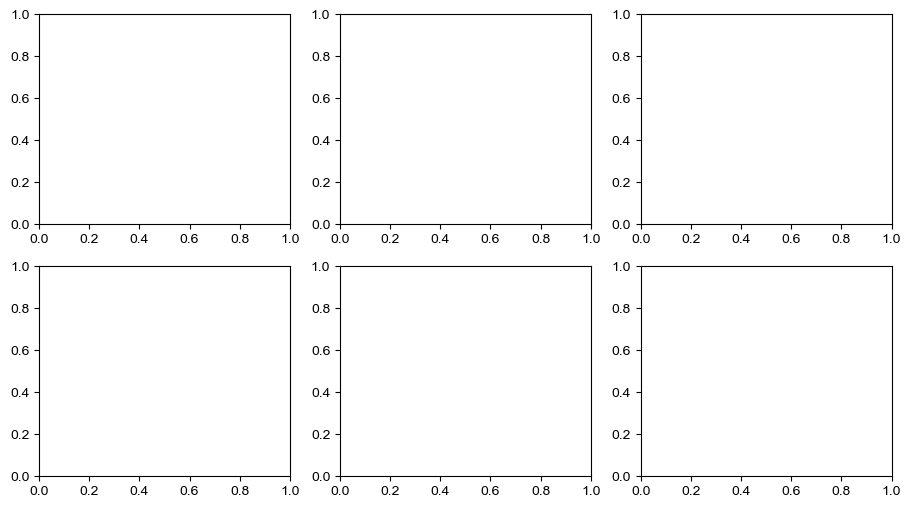

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(11, 6)) #2 rows by 3 columns
sns.set_style('white')

In [24]:
populationdata_active_population = np.nan*np.ones((1, window_size)) # The second _population refers to population across all animals and FOVs
populationdata_inactive_population = np.nan*np.ones((1, window_size))

for animal in early_test:
    FOVs = os.listdir(os.path.join(early_rein_dir, animal))
    for fov in sorted(FOVs):
        print('Early', animal, fov)
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(early_rein_dir, animal, fov),
                                                            window_size, pre_window_size)
        
        populationdata_active_population = np.vstack((populationdata_active_population, temp1))
        populationdata_inactive_population = np.vstack((populationdata_inactive_population, temp2))

Early CTL1 FOV1_tracked
active =  (54,)     inactive =  (8,)


UnboundLocalError: local variable 'framenumberfor_eventofinterest' referenced before assignment